## Regression

In this lecture, I show how easy and practical is to engineer features in an entire dataset utilising Feature-engine and the scikit-learn pipeline using the [Ames House Prices dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, log_loss

# for feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce

In [2]:
# load training data
data = pd.read_csv('../data/house-prices/train.csv')

In [3]:
# make lists of variable types

categorical = [var for var in data.columns if data[var].dtype == 'O']

year_vars = [var for var in data.columns if 'Yr' in var or 'Year' in var]

discrete = [
    var for var in data.columns if data[var].dtype != 'O'
    and len(data[var].unique()) < 20 and var not in year_vars
]

numerical = [
    var for var in data.columns if data[var].dtype != 'O'
    if var not in discrete and var not in ['Id', 'SalePrice']
    and var not in year_vars
]

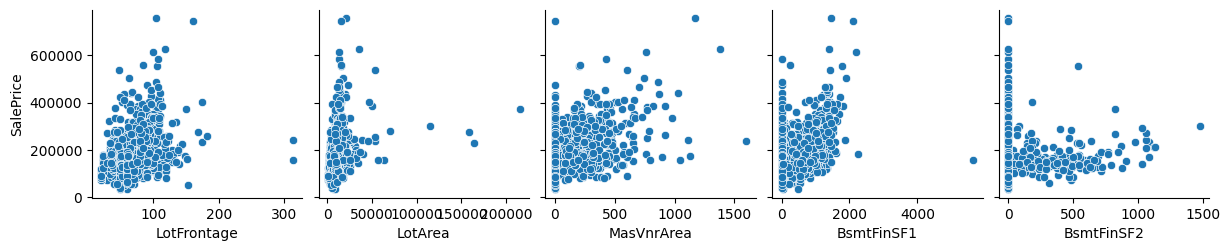

In [4]:
# some plots to get familiar with the variable distributions

sns.pairplot(data=data,
             y_vars=['SalePrice'],
             x_vars=['LotFrontage',
                     'LotArea',
                     'MasVnrArea',
                     'BsmtFinSF1',
                     'BsmtFinSF2', ])

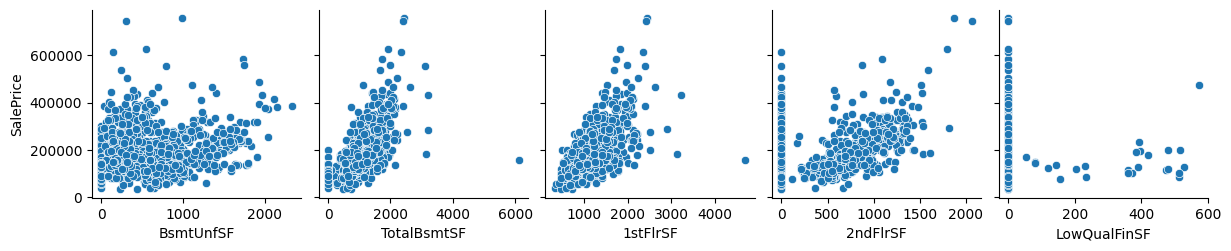

In [5]:
sns.pairplot(data=data,
             y_vars=['SalePrice'],
             x_vars=['BsmtUnfSF',
                     'TotalBsmtSF',
                     '1stFlrSF',
                     '2ndFlrSF',
                     'LowQualFinSF', ])

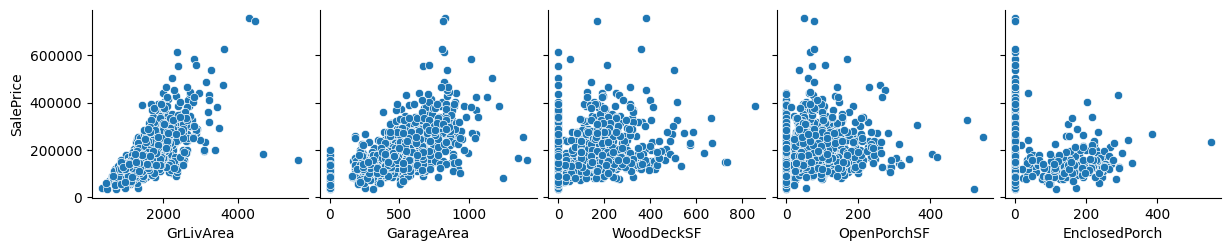

In [6]:
sns.pairplot(data=data,
             y_vars=['SalePrice'],
             x_vars=['GrLivArea',
                     'GarageArea',
                     'WoodDeckSF',
                     'OpenPorchSF',
                     'EnclosedPorch', ])

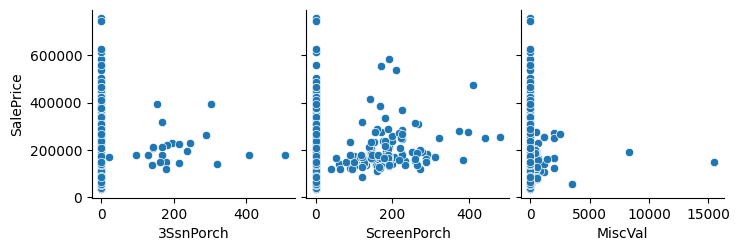

In [7]:
sns.pairplot(data=data,
             y_vars=['SalePrice'],
             x_vars=['3SsnPorch',
                     'ScreenPorch',
                     'MiscVal'])

In [8]:
# we are going to treat discrete variables as categorical 
# thus, to allow Feature-engine to pick them up automatically
# we need to re-cast them as object

data[discrete] = data[discrete].astype('O')

In [9]:
# split training data into train and test

X_train, X_test, y_train, y_test = train_test_split(data.drop(
    ['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.1,
    random_state=0)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

In [10]:
# transform year variables:
# calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [11]:
# drop YrSold

X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [12]:
house_pipe = Pipeline([

    # ===  missing data imputation =======
    # add missing indicator to variables that show NA
    ('missing_ind', mdi.AddMissingIndicator(missing_only=True)),

    # impute numerical variables with the median - vars automatically identified
    ('imputer_num',  mdi.MeanMedianImputer(imputation_method='median')),

    # impute categorical variables with a string, vars automatically identified
    # with return_object set to true, the numerical variables are cast as object
    # so that the encoders can identify them automatically
    ('imputer_cat', mdi.CategoricalImputer(return_object=True)),


    # === categorical encoding =========
    # group infrequent labels into a group, called "Rare"
    # categorical variables automatically identified
    ('rare_label_enc', ce.RareLabelEncoder(tol=0.1, n_categories=1)),

    # encode categories with the predictions from a tree
    # categorical variables automatically identified
    ('categorical_enc', ce.DecisionTreeEncoder(
        param_grid={'max_depth': [1, 2,3]},
        random_state=2909)),

    # === discretisation =====
    # transform numerical variables into tree predictions
    # need to specify variable names, because by now, all variables
    # will be numerical. Otherwise transformer will transform all
    ('discretisation', dsc.DecisionTreeDiscretiser(
        param_grid={'max_depth': [1, 2, 3]},
        random_state=2909,
        variables=numerical)),

    # feature Scaling
    ('scaler', StandardScaler()),

    # regression
    ('lasso', Lasso(alpha=100, random_state=0, max_iter=1000)),
])

In [13]:
# let's fit the pipeline
house_pipe.fit(X_train, y_train)

# let's get the predictions
X_train_preds = house_pipe.predict(X_train)
X_test_preds = house_pipe.predict(X_test)

In [14]:
# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds, squared=True)))
print('train rmse: {}'.format(mean_squared_error(y_train, X_train_preds, squared=False)))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds,squared=True)))
print('test rmse: {}'.format(mean_squared_error(y_test, X_test_preds, squared=False)))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 734128437.2837787
train rmse: 27094.80461792959
train r2: 0.8824234137312752

test mse: 1204916848.2120206
test rmse: 34711.912194692195
test r2: 0.8246657982364236
